In [9]:
import numpy as np
from scipy.stats import multivariate_normal
from skimage.restoration import wiener

# 準備するフィルタのサイズを5x5に固定
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
gauss_filters = []
std = 0.8
f = np.vectorize(
    lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y])
)
kernel = f(X, Y)
kernel = kernel / kernel.sum()
kernel = kernel.astype(np.float32)
gauss1 = kernel

tc.random.manual_seed(0)
kernel = tc.rand((5, 5))
kernel = kernel / kernel.sum()
random1 = kernel

In [66]:
import numpy as np
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch as tc
from scipy.signal import fftconvolve
from torch import nn
from torch.nn import functional as F

tc.random.manual_seed(0)
# idx: 0: gauss, 1: random
blur_kernels = [gauss1, random1]

class BluredMNIST(MNIST):
    def __getitem__(self, index):
        '''blur img and change target'''
        img, target = super().__getitem__(index)
        blur_index = tc.randint(0, 1, ())
        blur_kernel = blur_kernels[blur_index]
        img = fftconvolve(img[0], blur_kernel, mode='same')
        return img[np.newaxis, :], blur_index
        
transform = transforms.Compose([transforms.ToTensor()])
trainset = BluredMNIST(root='data/', train=True, download=True, transform=transform)
testset = BluredMNIST(root='data/', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, shuffle=True, batch_size=32)
testloader = DataLoader(testset, shuffle=False)

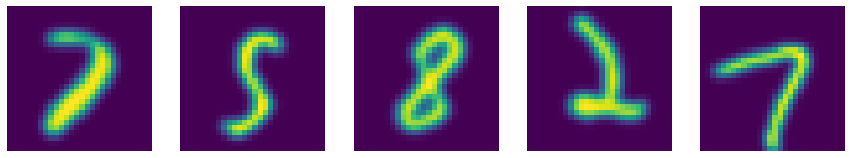

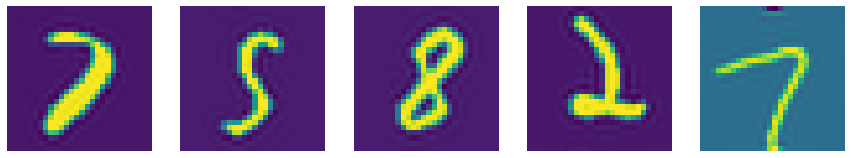

In [70]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.restoration import wiener

train_data = iter(trainloader)
data = [next(train_data) for _ in range(5)]

plt.figure(figsize=(15, 5))
for i, (img, label) in enumerate(data, start=1):
    plt.subplot(1, 5, i)
    plt.imshow(img[0][0])
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))
for i, (img, label) in enumerate(data, start=1):
    img, label = img[0][0], label[0]
    restore = wiener(img.numpy(), blur_kernels[label], 1e-4)
    plt.subplot(1, 5, i)
    plt.imshow(restore)
    plt.axis('off')
plt.show()

In [ ]:
# 20x20

In [59]:
class AutoEncoder1(nn.Module):
    def __init__(self):
        super(AutoEncoder1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 4, 5)
        self.conv_transpose1 = nn.ConvTranspose2d(4, 8, 5)
        self.conv_transpose2 = nn.ConvTranspose2d(8, 1, 5)
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
        
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        return x

In [71]:
from torch import optim
device = tc.device('cuda:0')
tc.random.manual_seed(1000)

auto_encoder = AutoEncoder1()
auto_encoder.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(auto_encoder.parameters(), lr=0.01)
for epoch in range(1):
    for images, label in trainloader:
        images = images.to(device)
        x = auto_encoder(images)
        optimizer.zero_grad()
        loss = loss_fn(x, images)
        loss.backward()
        optimizer.step()

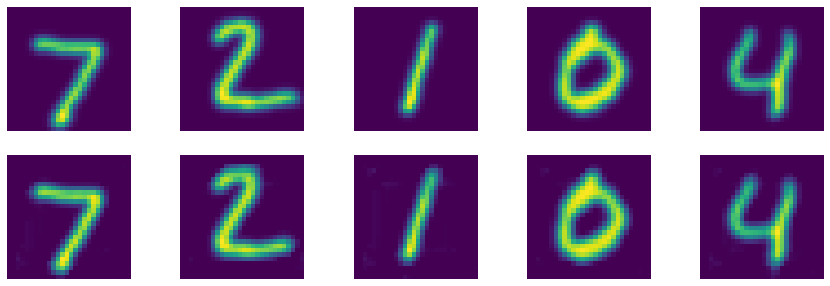

In [72]:
from matplotlib import pyplot as plt
import numpy as np
data = iter(testloader)
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    images, _ = next(data)
    images = images.to(device)
    ax = axes[0][i]
    ax.imshow(images[0][0].cpu())
    ax.axis('off')
    
    with tc.no_grad():
        reconstruct_images = auto_encoder(images)
    ax = axes[1][i]
    ax.imshow(reconstruct_images[0][0].cpu())
    ax.axis('off')
plt.show()

In [73]:
images, _ = next(iter(trainloader))
images = images.to(device)
vec = auto_encoder.encode(images)
vec.shape

torch.Size([32, 4, 20, 20])

In [74]:
tc.save(auto_encoder.state_dict(), '../AE_mnist20x20.pth')

In [47]:
# 16x16

In [43]:
import torch as tc
from torch import nn
from torch.nn import functional as F


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 6, 5)
        self.conv3 = nn.Conv2d(6, 4, 5)
        self.conv_transpose1 = nn.ConvTranspose2d(4, 6, 5)        
        self.conv_transpose2 = nn.ConvTranspose2d(6, 8, 5)
        self.conv_transpose3 = nn.ConvTranspose2d(8, 1, 5)
    
    def forward(self, x):
        x = self.encode(x)
        return self.decode(x)
        
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.conv_transpose1(x))
        x = F.relu(self.conv_transpose2(x))
        x = F.relu(self.conv_transpose3(x))
        return x

In [44]:
from torch import optim
device = tc.device('cuda:0')

auto_encoder = AutoEncoder()
auto_encoder.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(auto_encoder.parameters(), lr=0.01)
for epoch in range(3):
    for images, label in trainloader:
        images = images.to(device)
        x = auto_encoder(images)
        optimizer.zero_grad()
        loss = loss_fn(x, images)
        loss.backward()
        optimizer.step()

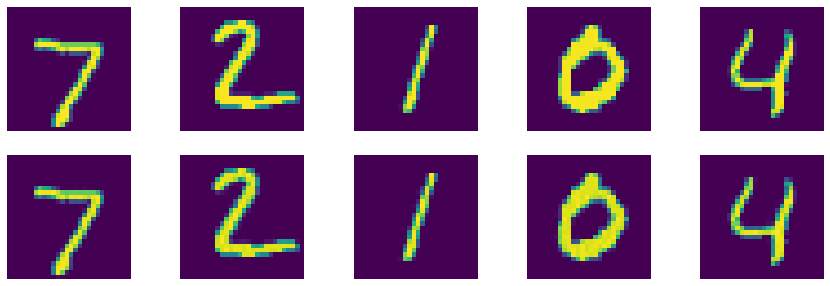

In [30]:
from matplotlib import pyplot as plt
import numpy as np
data = iter(testloader)
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    images, _ = next(data)
    images = images.to(device)
    ax = axes[0][i]
    ax.imshow(images[0][0].cpu())
    ax.axis('off')
    
    with tc.no_grad():
        reconstruct_images = auto_encoder(images)
    ax = axes[1][i]
    ax.imshow(reconstruct_images[0][0].cpu())
    ax.axis('off')
plt.show()

In [45]:
images, _ = next(iter(trainloader))
images = images.to(device)
vec = auto_encoder.encode(images)
vec.shape

torch.Size([4, 4, 16, 16])

In [46]:
tc.save(auto_encoder.state_dict(), '../AE_mnist16x16.pth')